# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return
def display_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(1+np.abs(fshift))
    return plt.imshow(magnitude_spectrum, cmap="gray")


--2021-11-28 08:24:28--  https://perso.telecom-paristech.fr/anewson/doc/images/palma.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770583 (753K) [image/png]
Saving to: ‘palma.png’

palma.png           100%[===================>] 752.52K  1.29MB/s    in 0.6s    

2021-11-28 08:24:29 (1.29 MB/s) - ‘palma.png’ saved [770583/770583]



(600, 800)

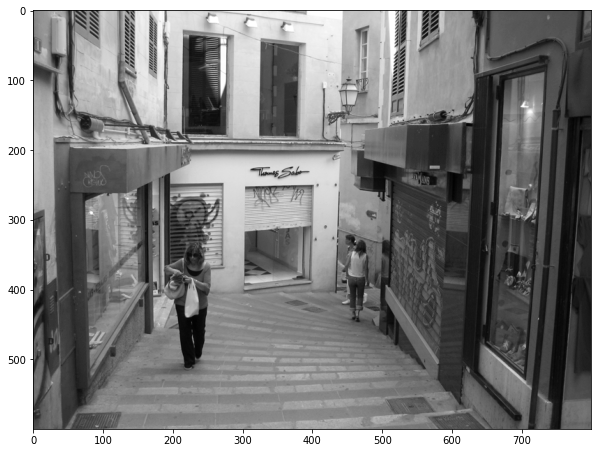

In [2]:

file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixe values to the range $(0,1)$.

In [3]:

def add_gaussian_noise(img_in,sigma_noise = 0.01):

  #INSERT CODE HERE
  normal_noise = np.random.normal(0,sigma_noise,img_in.shape)
  img_out = img_in + normal_noise
  img_out = np.clip(img_out,0,1)
  return img_out


def add_impulse_noise(img_in,p=0.9):
  #INSERT CODE HERE
  w,h = img_in.shape
  img_out = np.zeros((w,h))
  for i in range(w):
    for j in range(h):
      img_out[i,j] =  np.random.binomial(1,p)*img_in[i,j] + (1-np.random.binomial(1,p))*np.random.binomial(1,0.5)
  img_out = np.clip(img_out,0,1)
  return img_out

def add_missing_pixels_noise(img_in,p=0.9):
  #INSERT CODE HERE
  img_out = img_in*np.random.binomial(1,p)
  img_out = np.clip(img_out,0,1)
  return img_out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$ (the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [4]:
sigma_noise = 0.05
p = 0.9
#INSERT CODE HERE
img_gray_gaussian = add_gaussian_noise(img_gray,sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

#INSERT CODE HERE
img_gray_impulse = add_impulse_noise(img_gray,p)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')

#INSERT CODE HERE
img_gray_missing = add_missing_pixels_noise(img_gray,p)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question 3.1__ For each type of noise, propose a restoration filter (see course slides) 

__Answer__: we can simply use a gaussian filter for the gaussin noise, and a median filter for the impluse noise and missing pixels noise

Implement these restoration techniques in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__Note__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented

In [5]:
from scipy import ndimage

def gaussian_filter(img,sigma = 3):
  #INSERT CODE HERE
  img_out = ndimage.gaussian_filter(img,sigma)
  return img_out


def median_filter(img,median_size):
  #INSERT CODE HERE
  img_out = ndimage.median_filter(img,median_size)
  return img_out

sigma_gauss = 1.0
img_out_gaussian = gaussian_filter(img_gray_gaussian,sigma_gauss)
write_image(img_out_gaussian,file_name+'_denoised_gaussian.png')

median_size = 3
img_out_impulse_median = median_filter(img_gray_impulse,median_size)
write_image(img_out_impulse_median,file_name+'_impulse_denoised_median.png')

img_out_missing_median = median_filter(img_gray_missing,median_size)
write_image(img_out_missing_median,file_name+'_missing_denoised_median.png')

__Question 3.2__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__ : The more noise we wish to eliminate, the worse the image quality will be.

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only__. 

Text(0.5, 1.0, 'PSNR variation with respect to sigma')

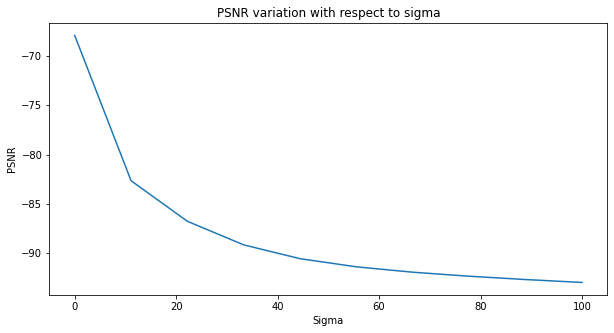

In [11]:
def PSNR(img,img_ref):
    #INSERT CODE HERE
    n,m = img.shape
    mse = (1/m*n) * np.sum((img-img_ref)**2)
    psnr = -10*np.log(mse)
    return psnr

#INSERT CODE HERE

sigmas = np.linspace(0,100,10)
psnr_wrt_sigma = [PSNR(img_gray,gaussian_filter(img_gray_gaussian,sigma)) for sigma in sigmas]


plt.figure(figsize=(10,5))
plt.plot(sigmas,psnr_wrt_sigma)
plt.xlabel("Sigma")
plt.ylabel("PSNR")
plt.title("PSNR variation with respect to sigma")


## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


--2021-11-28 08:27:23--  https://perso.telecom-paristech.fr/anewson/doc/images/boston.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626414 (612K) [image/png]
Saving to: ‘boston.png’

boston.png          100%[===================>] 611.73K  1.05MB/s    in 0.6s    

2021-11-28 08:27:25 (1.05 MB/s) - ‘boston.png’ saved [626414/626414]



(600, 600)

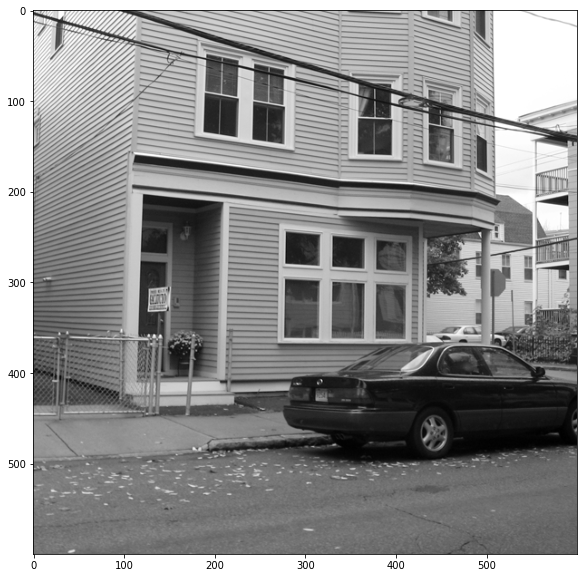

In [12]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

(600, 600)


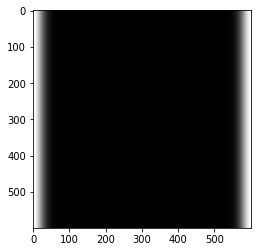

In [13]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ and write the result ``img_convolved`` to an output file


In [14]:
#INSERT CODE HERE
img_fft = np.fft.fft2(img_gray)
#img_ftt = np.fft.fftshift(img_fft)
img_convolved_fft = img_fft * f_hat
img_convolved = np.fft.ifft2(img_convolved_fft)
img_convolved = np.real(img_convolved)

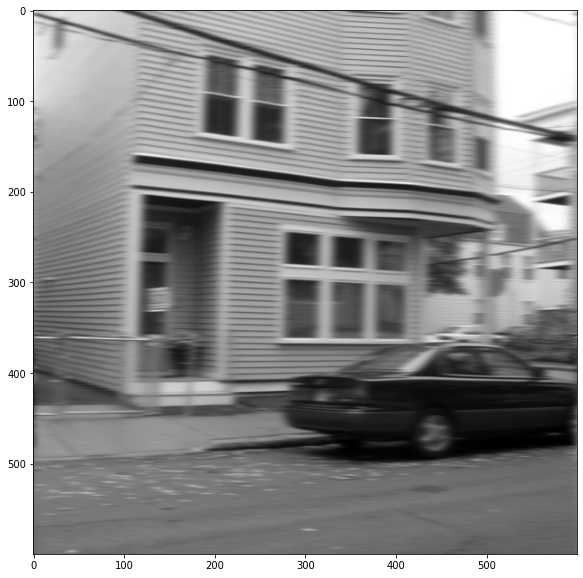

In [15]:
display_image(img_convolved)

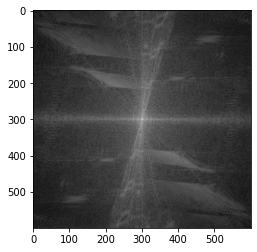

In [16]:
display_spectrum(img_gray)

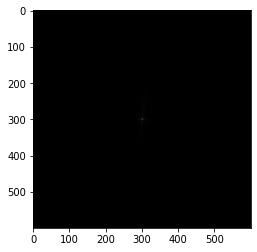

In [17]:
display_spectrum(img_convolved)

__Question 3.3__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ? How can this happen in real life ? 

__Answer__: When we look closly to the spectrum's magnitude of the convolved image, we can see a small dot in the middle. And if we compare this with the spectrum of the unfiltred image, we can say that the filter's role is to reduce the magnitude of the image frequencies, thus inducing a blurring effect. This effect can happen by taking images while moving a lot, or it can happen by taking images of fast moving objects.

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue (look at the formula at the beginning of this section on deconvolution).


In [18]:
def deconvolve_fourier(img,f_hat):
    #INSERT CODE HERE
    img_fft = np.fft.fft2(img)
    img_fft = np.fft.fftshift(img_fft)
    real_img = img_fft / (f_hat+ 1e-10)
    img_out = np.fft.ifft2(np.fft.ifftshift(real_img))
    return img_out
    

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')